In [1]:
import re
import sys
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F


Bad key "text.kerning_factor" on line 4 in
C:\Users\samsu\anaconda3\envs\tensorflow_gpu\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
#https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py

class EarlyStopping:
    def __init__(self, patience=8, verbose=True, delta=0, path='checkpoint.pt', trace_func=print):
        
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}\n')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ... \n')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [3]:
#To test a single line data for visulaisation 
def compute_accuracy_test(output, gold):
    try:
        assert(len(output) == len(gold))
    except:
        print("Different number of words in the two lists!")
        return -1

    count_correct = 0
    count_total_tokens = 0
    for o_sent,g_sent in zip(output,gold):
        check = [o_token == g_token for o_token,g_token in zip(o_sent,g_sent)]
        count_correct += sum(check)
        count_total_tokens += len(check)
    return count_correct/count_total_tokens

def compute_accuracy(output, gold):
    try:
        assert(len(output) == len(gold))
    except:
        print("Different number of lines in the two files!")
        return -1

    count_correct = 0
    count_total_tokens = 0
    for o_sent,g_sent in zip(output,gold):
        try:
            assert(len(o_sent)==len(g_sent))
        except:
            print("Different number of tokens in the two lines!")
            return -1
        check = [o_token[1] == g_token[1] for o_token,g_token in zip(o_sent,g_sent)]
        count_correct += sum(check)
        count_total_tokens += len(check)
    return count_correct/count_total_tokens

### Reading and preparing the file for training

In [4]:
from collections import Counter
#encoding="ISO-8859-1"
def read_data(f):
    with open(f, encoding = "utf-8",) as inp:
        lines = inp.readlines()
        if len(lines) == 0:
            raise ValueError('This file is empty')
        else:
            print('='*20+'Reading the file'+'='*20)
    data = []
    for line in lines:
        line = line.strip().split()
        sentence = []
        for token in line:
            token = token.split('|')
            word = token[0]
            tag = token[1]
            sentence.append((word,tag))
        data.append(sentence)
    return data

def convert_data_for_training(data):
    for d in data:
        tokens = [t[0] for t in d]
        tags = [t[1] for t in d]
    return [([t[0] for t in d],[t[1] for t in d]) for d in data]

TRAINING_FILE = "data/irish.train"
training_data = convert_data_for_training(read_data(TRAINING_FILE))

DEV_FILE = "data/irish.dev"
dev_data = convert_data_for_training(read_data(DEV_FILE))

TEST_FILE = "data/irish.test"
test_data = convert_data_for_training(read_data(TEST_FILE))

====================Reading the file====================
====================Reading the file====================
====================Reading the file====================


### Rare words are assigned as UNK 
Run the Below cell if you want to replace the rare words with 'UNK'

In [5]:
def substitute_with_UNK(data, n=1):
    
    doc = ''
    for i in range(len(data)):
        s = ' '.join(data[i][0])
        doc = doc + ' ' + s
    
    words = doc.lower().split()    
    wordfreq = [words.count(p) for p in words]
    words_UNK = words.copy()
    #freqdict = dict(list(zip(words,wordfreq)))
    
    # Find all words that appear <= n times in the corpus
    # Iterate through the corpus and substitute the rare words with UNK
    for i in range(len(wordfreq)):
        if(wordfreq[i]==n):
            words_UNK[i] = 'UNK'
    data = [words,words_UNK]
    return data

data = substitute_with_UNK(training_data, n=1)
words = data[0].copy()
words_unk = data[1].copy()

word_to_ix = {}#{'<pad>': 0}
ix_to_word = {}#{0: '<pad>'}
char_to_ix = {'$': 0}# $ is to represent unknown character
ix_to_char = {0: '$'}
word_len_max = 0
for word in words_unk:
    if word not in word_to_ix:
        word_to_ix[word] = len(word_to_ix)
        ix_to_word[word_to_ix[word]] = word
    for char in word:
        if char not in char_to_ix:
            char_to_ix[char] = len(char_to_ix)
            ix_to_char[char_to_ix[char]] = char        
        
tag_to_ix = {}
ix_to_tag = {}
for sent, tags in training_data:
    for tag in tags:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)
            ix_to_tag[tag_to_ix[tag]] = tag

NOTE: Create the tokens using 'words_UNK', then we will have a UNK word token and rare words wont have any tokens of their own.
 Now we can use 'words', to train the model where rare words should be assigned to UNK token using if else statement. 

### Tokenizing the words and tags

In [6]:
def prepare_sequence(seq, to_ix):
    sequence = []
    for w in seq:
        if w in to_ix:
            sequence.append(to_ix[w])
        else:
            sequence.append(to_ix['UNK'])
    return sequence

def reverse_sequence(seq, to_word):
    sentence = []
    for w in seq:
        if w in to_word:
            sentence.append(to_word[w])
    return sentence

def prepare_sequence_char(seq, to_ix):
    sequence = []
    for w in seq:
        for c in w:
            if c in to_ix:
                sequence.append(to_ix[c])
            else:
                sequence.append(to_ix['$'])
    return sequence

### Building and Deploying the model

Pass the sentence in model(sentence) to the model. Then break each sentence and then each word again take each character to prepare a sequence at char level for a given word, then add the embeddings and save them in a tensor and form the sequence of numbers. From there on we can concat both the embedding output (word and char) along thier dimension (eg 32+32=64), then pass these into the linear layer.

In [18]:
class LSTMTagger(nn.Module):

    def __init__(self, word_embedding_dim, char_embedding_dim, hidden_dim, vocab_size, output_size, char_size):
        
        super(LSTMTagger, self).__init__()
        
        self.word_embedding_dim = word_embedding_dim
        self.char_embedding_dim = char_embedding_dim
        self.hidden_dim = hidden_dim
        
        self.word_embeddings = nn.Embedding(vocab_size, word_embedding_dim)
        self.char_embeddings = nn.Embedding(char_size, char_embedding_dim)
        self.lstm = nn.LSTM(char_embedding_dim + word_embedding_dim, hidden_dim, batch_first = True)
        self.hidden2tag = nn.Linear(hidden_dim, output_size)

    def forward(self, seq, sentence):
        
        word_embeds = self.word_embeddings(seq)
        
        char_embeds = []
        for word in sentence:
            embeds = 0
            char_seq = prepare_sequence_char(word, char_to_ix)
            embeds = self.char_embeddings(torch.LongTensor(char_seq))
            to_word = torch.sum(embeds, dim = 0)
            char_embeds.append(torch.Tensor(to_word))
            
        char_embeds = torch.stack(char_embeds)
        
        embeds_cat = torch.cat((word_embeds, char_embeds), dim=1)
        embeds_cat = embeds_cat.view(-1, embeds_cat.shape[0], embeds_cat.shape[1])
        
        lstm_out, _ = self.lstm(embeds_cat)
        tag_space = self.hidden2tag(lstm_out.view(-1, self.hidden_dim))        
        tag_scores = F.log_softmax(tag_space, dim=1)
        
        return tag_scores

In [19]:
def train_model(model, patience, n_epochs):
    
    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = []
    
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(n_epochs):
        print(f"Starting epoch {epoch+1}...")
        
        #Sets the model in training mode where training is set to True to utilise any 
        #regularisation/BatchNormalization if available.  
        model.train()
        for sentence, tags in training_data:
            model.zero_grad()
        
            tag_scores = model(torch.LongTensor(prepare_sequence(sentence, word_to_ix)), sentence)
            tags = torch.LongTensor(prepare_sequence(tags, tag_to_ix))
            
            loss = loss_function(tag_scores, tags)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        #Sets the model in evaluation mode where training is set to False to avoid any 
        #regularisation/BatchNormalization if available.    
        model.eval()
        for sentence, tags in dev_data:
            
            tag_scores = model(torch.LongTensor(prepare_sequence(sentence, word_to_ix)), sentence)
            tags = torch.LongTensor(prepare_sequence(tags, tag_to_ix))
            
            loss = loss_function(tag_scores, tags)
            valid_losses.append(loss.item())

        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print(f'[{epoch+1:>{epoch_len}}/{n_epochs:>{epoch_len}}]' +'-'*20+'->'+
                     f'train_loss: {train_loss:.5f}   ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        # Empty lists again for the next epoch
        train_losses = []
        valid_losses = []
        
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping"+'-'*10 +"STOPPED")
            break
        
    # loading the last best the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

In [27]:
word_embedding_dim = 32
char_embedding_dim = 32
hidden_dim = 64
epochs = 20
patience = 5

model = LSTMTagger(word_embedding_dim, char_embedding_dim, hidden_dim, len(word_to_ix), len(tag_to_ix), len(char_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

model, train_loss, valid_loss = train_model(model, patience, epochs)

Starting epoch 1...
[ 1/20]--------------------->train_loss: 0.63106   valid_loss: 0.52945
Validation loss decreased (inf --> 0.529454).  Saving model ... 

Starting epoch 2...
[ 2/20]--------------------->train_loss: 0.39536   valid_loss: 0.46982
Validation loss decreased (0.529454 --> 0.469821).  Saving model ... 

Starting epoch 3...
[ 3/20]--------------------->train_loss: 0.35001   valid_loss: 0.47298
EarlyStopping counter: 1 out of 5

Starting epoch 4...
[ 4/20]--------------------->train_loss: 0.33378   valid_loss: 0.45869
Validation loss decreased (0.469821 --> 0.458692).  Saving model ... 

Starting epoch 5...
[ 5/20]--------------------->train_loss: 0.32253   valid_loss: 0.46694
EarlyStopping counter: 1 out of 5

Starting epoch 6...
[ 6/20]--------------------->train_loss: 0.31252   valid_loss: 0.45444
Validation loss decreased (0.458692 --> 0.454438).  Saving model ... 

Starting epoch 7...
[ 7/20]--------------------->train_loss: 0.31386   valid_loss: 0.47329
EarlyStopping 

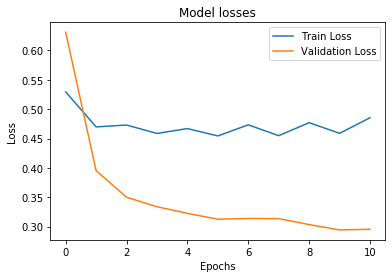

In [28]:
plt.plot(train_loss)
plt.plot(valid_loss)
plt.title('Model losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [29]:
with torch.no_grad():
    inputs = torch.LongTensor(prepare_sequence(test_data[0][0], word_to_ix))
    tag_scores = model(inputs, test_data[0][0])

    #print(tag_scores)
    # Print the actual words with their tags
    for i,word in enumerate(test_data[0][0]):
        j = int(np.argmax(tag_scores[i]))
        print(f"\t{word}|{ix_to_tag[j]}|{test_data[0][1][i]}")

	Crothnófar|VERB|VERB
	Pól|PROPN|PROPN
	nó|CCONJ|SCONJ
	ba|AUX|AUX
	úrlabhraí|NOUN|NOUN
	maith|ADJ|ADJ
	é|PRON|PRON
	ar|ADP|ADP
	Raidió|PROPN|PROPN
	na|DET|DET
	Gaeltachta|PROPN|PROPN
	agus|CCONJ|CCONJ
	na|DET|DET
	meáin|NOUN|NOUN
	eile|DET|DET
	ag|ADP|ADP
	cosaint|NOUN|NOUN
	na|DET|DET
	n-oifigí|NOUN|NOUN
	poist|NOUN|NOUN
	tuaithe|NOUN|NOUN
	,|PUNCT|PUNCT
	gné|NOUN|NOUN
	am-tábhachtach|NOUN|ADJ
	de|ADP|ADP
	shaol|NOUN|NOUN
	sóisialta|ADJ|ADJ
	na|DET|DET
	ndaoine|NOUN|NOUN
	.|PUNCT|PUNCT


In [30]:
pred = []
true = []
for i in range(len(test_data[0][1])):
    pred.append(ix_to_tag[int(np.argmax(tag_scores[i]))])
    true.append(test_data[0][1][i])

compute_accuracy_test(pred,true)

0.9652173913043478

In [33]:
with torch.no_grad():
    #This will be the file to write the outputs
    with open("data/mymodel_output_irish.output", 'w', encoding = "utf-8") as op:
        for instance in test_data:
            # Convert the test sentence into a word ID tensor
            inputs = torch.LongTensor(prepare_sequence(instance[0], word_to_ix))
            # Forward pass
            tag_scores = model(inputs, instance[0])
            # Find the tag with the highest probability in each position
            outputs = [int(np.argmax(ts)) for ts in tag_scores]
            # Prepare the output to be written in the same format as the test file (word|tag)
            formatted_output = ' '.join([f"{word}|{ix_to_tag[tag_id]}" for word,tag_id in zip(instance[0],outputs)])
            # Write the output
            op.write(formatted_output + '\n')

In [34]:
#Give the path of the OUTPUT file
OUTPUT_FILE = "data/mymodel_output_irish.output"
output = read_data(OUTPUT_FILE)

#Give the path of the ORIGINAL file
REFERENCE_FILE = 'data/irish.test'
gold = read_data(REFERENCE_FILE)

acc = compute_accuracy(output,gold)
print(acc)

====================Reading the file====================
====================Reading the file====================
0.8625976852309823
